### Imports

In [ ]:
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import math
import random

import torch
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Read the Data from Files

In [ ]:
# Convert time to cosine and sine
# Remove unnecessary points

In [ ]:
with ZipFile("training_set.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="training_set")
path = "training_set"

In [ ]:
#Ensure the folder is here
os.listdir()

## Data Processing

In [ ]:
#Get the features given one day
def extractFeatures(file, path):
  filepath = path + "/" + file
  df = pd.read_csv(filepath)
  if df.empty:
    return
  df['grid'] = df.apply(getGrid, axis = 1)
  df['month'] = df.apply(getMonth, axis = 1)
  df['day'] = df.apply(getDay, axis = 1)
  return df


In [ ]:
def getDay(row):
  date = row[2]
  parsed = date.split("-")
  parsed = parsed[2].split()
  day = parsed[0]
  return int(day)


In [ ]:
def getMonth(row):
  date = row[2]
  parsed = date.split("-")
  month = parsed[1]
  return int(month)

In [ ]:
min_long = 10000
min_lat = 1500

def getGrid(row):
  longitude = row['longitude']
  latitude = row['latitude']

  #This will turn a longitutde from 114.088852 -> 11408.8852 -> 11408
  short_long = str(math.floor(longitude * 100) - min_long)
  short_lat = "." + str(math.floor(latitude * 100) - min_lat)

  #Create a unique code for the grid
  grid = float(short_long + short_lat)
  return grid

In [ ]:
def getMostVisitedGrid(df):
  if df.empty:
    return [0,0]
  most_common_value = df['grid'].value_counts().idxmax()
  count = df['grid'].value_counts().max()

  return [most_common_value, count]

In [ ]:
def getNumberOfGridsVisited(df):
  return df['grid'].nunique()

In [ ]:
def getTime(date):
  #Date looks like: 	2016-07-01 00:00:03
  parsed = date.split()
  timeParsed = parsed[1].split(":")
  hours = int(timeParsed[0])
  minutes = int(timeParsed[1])
  seconds = int(timeParsed[2])
  return hours, minutes, seconds

In [ ]:
def getWorkTime(df):
  #We determine when to start by when status is first 1
  df = df.loc[df['status'] == 1]
  if df.empty:
    return [24, 0, 0, 0, 0, 0]
  df = df.sort_values(by=['time'])
  startRow = df.iloc[0]
  endRow = df.iloc[-1]
  
  startHour, startMinute, startSecond = getTime(startRow['time'])
  endHour, endMinute, endSecond = getTime(endRow['time'])
  return startHour, startMinute, startSecond, endHour, endMinute, endSecond

In [ ]:
def split_seek_serve(df):
  seek = df.loc[df['status'] == 0, ['grid','hours', 'minutes', 'seconds']]
  serve = df.loc[df['status'] == 1, ['grid','hours', 'minutes', 'seconds']]
  return seek, serve

In [ ]:
def number_trips(traj):

  numTrips = 0
  if traj[0][3] == 1:
    currentlyServing = True
  else:
    currentlyServing = False

  for trajectory in traj:
    status = trajectory[3]
    if status == 1 and currentlyServing:
      continue
    elif status == 1 and not currentlyServing:
      numTrips+=1
      currentlyServing = True
    elif status == 0 and currentlyServing:
      currentlyServing = False
    elif status == 0 and not currentlyServing:
      continue
  
  return numTrips

In [ ]:
#For the temporal features (time)
# Have three features for time
# Hour, minute, second
# Normalize them (they are different scale)

In [ ]:
def process_data(traj):
  """
  Input:
      Traj: a list of list, contains one trajectory for one driver 
      example:[[114.10437, 22.573433, '2016-07-02 00:08:45', 1],
         [114.179665, 22.558701, '2016-07-02 00:08:52', 1]]
  Output:
      Data: any format that can be consumed by your model.
  
  """
  # Data will be
  # month	day	mostVisitedGrid	timesVisited numberGridsVisited startTime	endTime numberOfTrips
  # seek[grid, timeInMinutes] serve[grid,timeInMinutes]

  if len(traj) == 0 :
    return

  df = pd.DataFrame(traj, columns = ['longitude', 'latitude', 'time', 'status'])

  #Sort by time (should be default)
  df = df.sort_values(by=['time'])

  #Get the Day and Month
  month = getMonth(traj[0])
  day = getDay(traj[0])

  #Get the grid for each row
  df['grid'] = df.apply(getGrid, axis = 1)
  

  #Get the time in minutes for every row
  df[['hours', 'minutes', 'seconds']] = df['time'].apply(lambda x: pd.Series(getTime(x)))

  #Get the most visited grid and the times visited that grid
  mostVisitedGrid, timesVisited = getMostVisitedGrid(df)

  #Get the number of grids visited
  numGridsVisited = getNumberOfGridsVisited(df)

  #Get the work time for the driver
  startHour, startMinute, startSecond, endHour, endMinute, endSecond = getWorkTime(df)

  #Get the number of trips
  numTrips = number_trips(traj)

  #Set up the seek and serve data
  seek, serve = split_seek_serve(df)
  seek_data = seek.values
  serve_data = serve.values
  
  if not np.any(serve_data):
    serve_data = np.array([[0.0, 0.0, 0.0, 0.0]])

  overall_data = [month, day, mostVisitedGrid, timesVisited, numGridsVisited, startHour, startMinute, startSecond, endHour, endMinute, endSecond, numTrips]

  return [month, day, overall_data, seek_data, serve_data]

Main Model
  seeking model 
  serving model
                overall_data


In [ ]:
#generate trajectories and label
def aggr(data):
    traj_raw = data.values[:,1:]
    traj = np.array(sorted(traj_raw,key = lambda d:d[2]))
    label = data.iloc[0][0]
    return [traj,label]

In [ ]:
def get_data(p):
  #Concatenates all of the data files
  list_of_data = []
  #Get all of the files in the directory
  for f in os.listdir(p):
    #Ensure we are only working with csv
      if f.endswith(".csv"):
          filepath = p + "/" + f
          df = pd.read_csv(filepath)

          if df.empty:
            continue

          #Create the trajectories
          trajectories = df.groupby('plate').apply(aggr)

          for trajectory in trajectories:
            #Get correct data format from trajectory
            data = process_data(trajectory[0])
            #Add the label to the beginning
            data.insert(0,trajectory[1])
            list_of_data.append(data)
            

  #Converts to dataframe
  #Should be plate, month, day, overall_data, seekData, serveData
  processed_data = pd.DataFrame(list_of_data, columns = ['plate','month','day','overall_data', 'seekData', 'serveData'])

  # #Sort by time
  processed_data = processed_data.sort_values(by=['month', 'day'])

  return processed_data


In [ ]:
processed_data = get_data(path)
processed_data

,plate,month,day,overall_data,seekData,serveData
10,0,7,1,"[7, 1, 1381.762, 542, 159, 0, 0, 3, 23, 59, 56...","[[1408.753, 0.0, 10.0, 38.0], [1408.753, 0.0, ...","[[1411.753, 0.0, 0.0, 3.0], [1411.753, 0.0, 0...."
11,1,7,1,"[7, 1, 1407.754, 345, 103, 0, 0, 9, 23, 59, 51...","[[1403.751, 0.0, 10.0, 10.0], [1403.751, 0.0, ...","[[1399.753, 0.0, 0.0, 9.0], [1399.753, 0.0, 0...."
12,2,7,1,"[7, 1, 1404.753, 216, 153, 0, 27, 38, 22, 34, ...","[[1409.754, 0.0, 0.0, 9.0], [1409.754, 0.0, 0....","[[1404.755, 0.0, 27.0, 38.0], [1404.755, 0.0, ..."
13,3,7,1,"[7, 1, 1412.755, 215, 236, 0, 0, 13, 23, 49, 2...","[[1411.754, 0.0, 8.0, 43.0], [1411.754, 0.0, 9...","[[1409.756, 0.0, 0.0, 13.0], [1410.757, 0.0, 0..."
14,4,7,1,"[7, 1, 1417.755, 372, 114, 0, 0, 5, 23, 58, 4,...","[[1404.753, 0.0, 8.0, 46.0], [1404.753, 0.0, 9...","[[1403.752, 0.0, 0.0, 5.0], [1403.752, 0.0, 0...."
...,...,...,...,...,...,...
155,0,12,26,"[12, 26, 1408.754, 343, 171, 0, 23, 25, 23, 59...","[[1408.755, 0.0, 8.0, 7.0], [1408.755, 0.0, 8....","[[1408.755, 0.0, 23.0, 25.0], [1408.754, 0.0, ..."
156,1,12,26,"[12, 26, 1411.754, 191, 128, 0, 7, 36, 23, 45,...","[[1390.752, 0.0, 11.0, 8.0], [1390.752, 0.0, 1...","[[1390.752, 0.0, 7.0, 36.0], [1390.752, 0.0, 7..."
157,2,12,26,"[12, 26, 1391.751, 247, 117, 14, 54, 30, 23, 5...","[[1391.751, 0.0, 7.0, 40.0], [1391.751, 0.0, 1...","[[1391.756, 14.0, 54.0, 30.0], [1391.756, 14.0..."
158,3,12,26,"[12, 26, 1403.752, 281, 216, 0, 0, 6, 23, 58, ...","[[1411.767, 0.0, 35.0, 53.0], [1411.767, 0.0, ...","[[1380.762, 0.0, 0.0, 6.0], [1380.761, 0.0, 0...."


In [ ]:
processed_data.to_csv('training_data.csv')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        data_point = self.features[index]
        overall_data = torch.tensor(data_point[0], dtype=torch.float32)
        seek_data = torch.tensor(data_point[1], dtype=torch.float32)
        serve_data = torch.tensor(data_point[2], dtype=torch.float32)
        label = torch.tensor(self.labels[index])
        return overall_data, seek_data, serve_data, label

In [ ]:
def createLabelsAndFeatures(processed_data):
  processed_data_numpy = processed_data.to_numpy()
  labels = np.array(processed_data_numpy[:,0])
  #Features will be [overall_data, seekData, serveData]
  features = processed_data_numpy[:,3:]
  return features, labels

In [ ]:
def createTrainingTestingSet(features, labels):
  #Features will be [overall_data, seekData, serveData]
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle = True)
  trainset = CustomDataset(X_train, y_train)
  testset = CustomDataset(X_test, y_test)
  train_set = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)
  test_set = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
  return train_set, test_set

In [ ]:
#New
features, labels = createLabelsAndFeatures(processed_data)
train_set, test_set = createTrainingTestingSet(features, labels)

## Model

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [ ]:
overall_data_size = 12
overall_output_size = 30
seek_data_size = 4
seek_output_size = 10
serve_data_size = 4
serve_output_size = 10
summary_input_size = overall_output_size + seek_output_size + serve_output_size
num_taxis = 5

class TaxiNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        #Seeking Layers
        self.seek_input_layer = nn.Linear(seek_data_size, 10)
        self.seek_lstm1 = nn.LSTM(10, 20)
        self.seek_linear1 = nn.Linear(20, seek_output_size)

        #Serving Layers
        self.serve_input_layer = nn.Linear(serve_data_size, 10)
        self.serve_lstm1 = nn.LSTM(10, 20)
        self.serve_linear1 = nn.Linear(20, serve_output_size)

        #Overall Layers
        self.overall_input_layer = nn.Linear(overall_data_size, overall_output_size)

        #Combined Layers
        self.combined_layer1 = nn.Linear(summary_input_size, 120)
        self.combined_layer2 = nn.Linear(120, 40)
        self.combined_layer3 = nn.Linear(40, num_taxis)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, seeking_data, serving_data, overall_data):

        # h_0 = Variable(torch.zeros(1, seeking_data.size(1), 40)) #hidden state
        # c_0 = Variable(torch.zeros(1, seeking_data.size(1), 40)) #internal state

        # h_1 = Variable(torch.zeros(1, serving_data.size(1), 40)) #hidden state
        # c_1 = Variable(torch.zeros(1, serving_data.size(1), 40)) #internal state

        #Seeking Layers
        seek_data = F.relu(self.seek_input_layer(seeking_data))
        seek_data, _ = self.seek_lstm1(seek_data)
        seek_data = seek_data[:,-1,:]
        # hn0 = hn0.view(-1, 40)
        # seek_data = F.relu(hn0)
        seek_data = F.relu(self.seek_linear1(seek_data))

        #Serving Layers
        serve_data = F.relu(self.serve_input_layer(serving_data))
        serve_data, _ = self.serve_lstm1(serve_data)
        serve_data = serve_data[:,-1,:]
        # hn1 = hn1.view(-1, 40)
        # serve_data = F.relu(hn1)
        serve_data = F.relu(self.serve_linear1(serve_data))

        #Overall layers
        overall_data = F.relu(self.overall_input_layer(overall_data))

        #Combined Layers
        data = torch.cat((seek_data, serve_data, overall_data), 1)
        data = F.relu(self.combined_layer1(data))
        data = F.relu(self.combined_layer2(data))
        data = F.relu(self.combined_layer3(data))
        data = self.softmax(data)
        return data

In [ ]:
net = TaxiNetwork().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 1
losses = []

In [ ]:
net.train()
for i in tqdm(range(epochs)):
  for overall_features, seek_features, serve_features, output in train_set:
    #Run the model
    optimizer.zero_grad()
    seek_features = seek_features.to(device)
    serve_features = serve_features.to(device)
    overall_features = overall_features.to(device)
    output = output.to(device)
    
    result = net(seek_features, serve_features, overall_features).to(device)
    print(output)
    print(result)
    loss = criterion(result, output)
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(loss)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([4], device='cuda:0')
tensor([[0.8272, 0.0057, 0.0057, 0.1171, 0.0444]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([2], device='cuda:0')
tensor([[0.4772, 0.0110, 0.0110, 0.3663, 0.1347]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([3], device='cuda:0')
tensor([[0.6310, 0.0081, 0.0081, 0.0081, 0.3448]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([4], device='cuda:0')
tensor([[0.1757, 0.0126, 0.0126, 0.3559, 0.4432]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
tensor([[2.5380e-05, 9.9420e-04, 5.5370e-07, 9.9896e-01, 1.5937e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([1], device='cuda:0')
tensor([[0.3408, 0.0129, 0.0129, 0.0987, 0.5346]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([1], device='cuda:0')
tensor([[0.5799, 0.0126, 0.0126, 0.0183, 0.3765]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([2], device='cuda:0')
tensor([[0.6272, 0.0138, 0.

  0%|          | 0/1 [00:03<?, ?it/s]

tensor([[0.5799, 0.0169, 0.0169, 0.0301, 0.3562]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([3], device='cuda:0')
tensor([[0.2992, 0.0200, 0.0200, 0.2971, 0.3638]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([3], device='cuda:0')
tensor([[0.8741, 0.0047, 0.0047, 0.0047, 0.1118]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([1], device='cuda:0')
tensor([[0.6989, 0.0180, 0.0180, 0.0244, 0.2406]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([2], device='cuda:0')
tensor([[0.5438, 0.0106, 0.0106, 0.0106, 0.4244]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
tensor([[4.2010e-03, 5.7123e-03, 6.1741e-04, 9.8097e-01, 8.5006e-03]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


KeyboardInterrupt: ignored

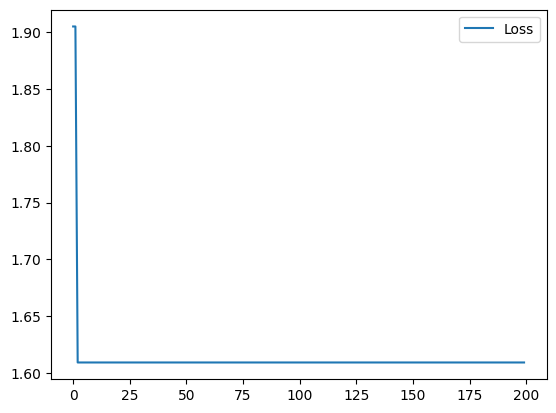

In [ ]:
plt.figure()
cpu_losses = []
for loss in losses:
  cpu_losses.append(loss.cpu().detach().numpy())
plt.plot(cpu_losses, label='Loss')
plt.legend()
plt.savefig('loss.png')

In [ ]:
#Save the model
torch.save({
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': loss
            }, 'model_save')

In [ ]:
net.eval()

correct = 0
total = 0
totalArray = [0,0,0,0,0]
correctArray = [0,0,0,0,0]
with torch.no_grad():
    for overall_features, seek_features, serve_features, output in test_set:
      #Run the seek model
      seek_features = seek_features.to(device)
      serve_features = serve_features.to(device)
      overall_features = overall_features.to(device)
      output = output.to(device)
      result = net(seek_features, serve_features, overall_features)
      result = result.to(device)
      for index, tensor_value in enumerate(result):
          totalArray[output[index]] += 1
          total += 1
          if torch.argmax(tensor_value) == output[index]:
              correctArray[output[index]] += 1
              correct += 1
                
accuracy = correct / total
print(f"Accuracy: {accuracy}")
print("Accuracy for each plate")
for i, total_plate in enumerate(totalArray):
    accuracy_per_plate = correctArray[i] / total_plate
    print(str(i) + ": " + str(accuracy_per_plate))

Accuracy: 0.18992248062015504
Accuracy for each plate
0: 1.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0


## Model Prediction

In [ ]:
def run(data,model):
    """
    
    Input:
        Data: the output of process_data function.
        Model: your model.
    Output:
        prediction: the predicted label(plate) of the data, an int value.
    
    """
    prediction = ""
    return prediction

In [ ]:
with ZipFile("validation_set.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path="validation_set")

validation_path = "validation_set"

In [ ]:
processed_validation_data = get_data(validation_path)
labels, features = createLabelsAndFeatures(processed_validation_data)
seeking = np.array([row[0] for row in features], dtype=float)
serving = np.array([row[0] for row in features], dtype=float)
labels = np.array(labels, dtype=float)
validationset = CustomTensorDataset(tensors=(torch.Tensor(seeking), torch.Tensor(serving), torch.Tensor(labels)))
validation_set = torch.utils.data.DataLoader(validationset, batch_size=1, shuffle=False)

network.eval()

correct = 0
total = 0
totalArray = [0,0,0,0,0]
correctArray = [0,0,0,0,0]
with torch.no_grad():
    for data in validation_set:
        seek_features, serve_features, output = data
        output = output.type(torch.LongTensor)
        seek_features = seek_features.to(device)
        serve_features = serve_features.to(device)
        output = output.to(device)
        result = network(seek_features, serve_features)
        for index, tensor_value in enumerate(result):
            totalArray[output[index]] += 1
            total += 1
            if torch.argmax(tensor_value) == output[index]:
                correctArray[output[index]] += 1
                correct += 1
                
accuracy = correct / total
print(f"Accuracy: {accuracy}")

print("Accuracy for each plate")
for i, total_plate in enumerate(totalArray):
    accuracy_per_plate = correctArray[i] / total_plate
    print(str(i) + ": " + str(accuracy_per_plate))